# Motion correction

In this tutorial, we will explore the problem of drift registration, i.e. how motion correction algorithms have been applied to extracellular recordings, and how we can use them in SpikeInterface

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

## What are the drifts?

![alternative text](drift.png)

## How can we deal with them ?

![alternative text](drift2.png)

## What do all the methods have in common?

![alternative text](drift3.png)

## What is implemented in SpikeInterface

![alternative text](drift4.png)

## Case study: motion estimation and correction on a 1min long recording

We load the data

In [2]:
import spikeinterface.full as si
from pathlib import Path
recording = si.read_binary_folder('/home/pierre/slice')
print(recording)

BinaryFolderRecording: 151 channels - 30.0kHz - 1 segments - 1,800,000 samples 
                       60.00s (1.00 minutes) - int16 dtype - 518.42 MiB


Now that we are preprocessing expert, we performed all the needed steps as a simple algorithmic pipelines, that will be executed on-the-fly

In [3]:
recording_preprocessed = si.phase_shift(recording, dtype='float32')
recording_preprocessed = si.highpass_filter(recording_preprocessed)
recording_preprocessed = si.common_reference(recording_preprocessed, reference='global')
recording_preprocessed = si.zscore(recording_preprocessed)

First, one can get a sense of possible drifts in the recordings by looking at a so-called "positional raster plot", i.e. the depth of the spike as function of time

In [4]:
from spikeinterface.sortingcomponents.peak_detection import detect_peaks
job_kwargs = dict(n_jobs=-1, chunk_duration='1s', progress_bar=True)
peaks = detect_peaks(recording_preprocessed,  method='locally_exclusive',
                     detect_threshold=5, exclude_sweep_ms=2, radius_um=50., **job_kwargs)

detect peaks using locally_exclusive:   0%|          | 0/60 [00:00<?, ?it/s]

Let's localize the peaks to get a sense of their putative depths. Several localization methods are available, let's use the grid_convolution (from KiloSort)

In [5]:
from spikeinterface.sortingcomponents.peak_localization import localize_peaks
peak_locations = localize_peaks(recording_preprocessed, peaks, method='monopolar_triangulation', radius_um=50., **job_kwargs)

localize peaks using monopolar_triangulation:   0%|          | 0/60 [00:00<?, ?it/s]

We can now display the positional raster plot

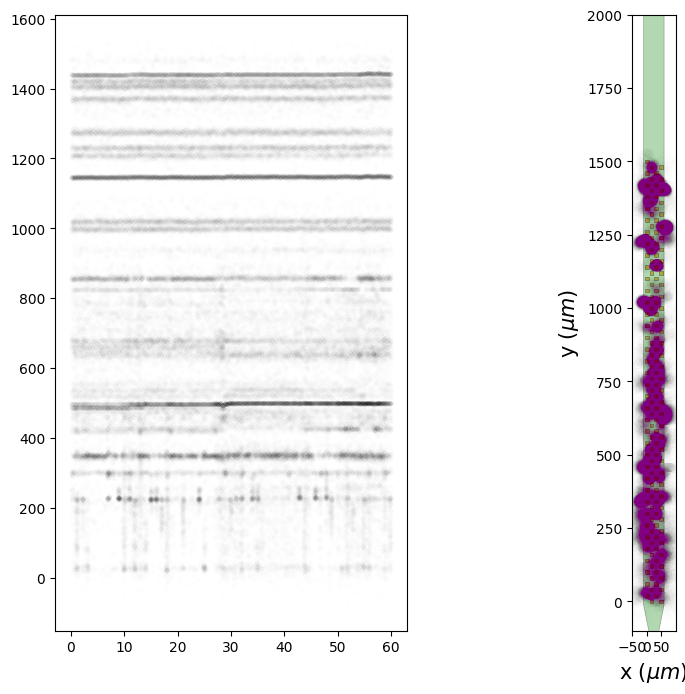

In [6]:
import pylab as plt
fs = recording_preprocessed.sampling_frequency
fig, ax = plt.subplots(ncols=2, squeeze=False, figsize=(10, 8))
ax[0, 0].scatter(peaks['sample_index'] / fs, peak_locations['y'], color='k', marker='.',  alpha=0.002)
si.plot_probe_map(recording_preprocessed, ax=ax[0, 1])
ax[0, 1].set_ylim(-100, 2000)
ax[0, 1].scatter(peak_locations['x'], peak_locations['y'], color='purple', alpha=0.002)


## Motion estimation

Now, we have all the ingredients to estimate the motion in this recording

In [16]:
motion_corrected = si.correct_motion(recording_preprocessed, preset='nonrigid_fast_and_accurate', 
                                     interpolate_motion_kwargs={'border_mode' : 'force_extrapolate'},
                                     folder='motion', **job_kwargs)

detect and localize:   0%|          | 0/60 [00:00<?, ?it/s]

In [17]:
motion_info = si.load_motion_info('motion')

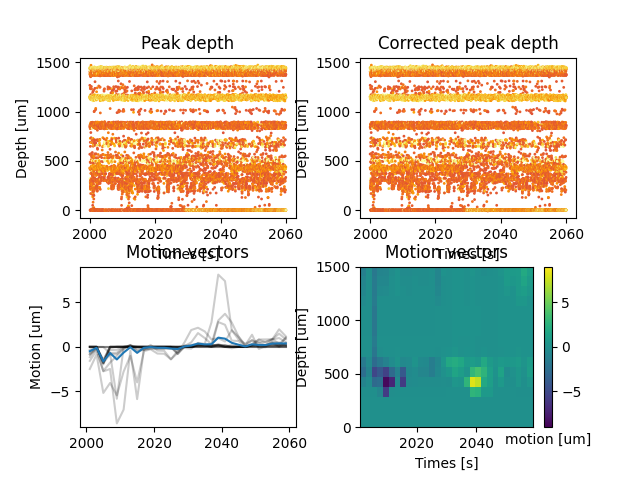

In [18]:
%matplotlib widget
si.plot_motion(motion_info, motion_corrected, amplitude_cmap='inferno', color_amplitude=True)

In [13]:
%matplotlib widget
si.plot_traces({'no correction' : recording_preprocessed, 'correction' : motion_corrected}, clim=(-4, 4), backend='ipywidgets')

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

Let's compare that to the KS method

In [14]:
motion_corrected_ks = si.correct_motion(recording_preprocessed, preset='kilosort_like', 
                                     interpolate_motion_kwargs={'border_mode' : 'force_extrapolate'},
                                     folder='motion_ks', **job_kwargs)

detect and localize:   0%|          | 0/60 [00:00<?, ?it/s]

In [15]:
motion_info_ks = si.load_motion_info('motion_ks')

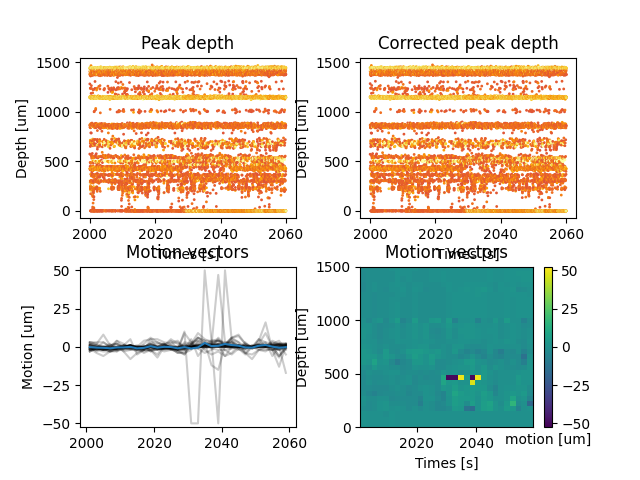

In [16]:
si.plot_motion(motion_info_ks, motion_corrected, amplitude_cmap='inferno', color_amplitude=True)